Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**


In [54]:
import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import datetime as dt
import numpy as np
import re

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")

%matplotlib inline
# plot dimensions
plot_width = 12
plot_height = 8
palette_success ={0: color_pal[1], 1: color_pal[2]}

# Business understanding
**Aktuelle Situation:**<br>
- Einzelhandelsunternehmen hat Verträge mit 4 versch. payment service provider (PSP) für Online-Kreditkartenzahlungen
- Auswahl eines PSPs für eine Überweisung erfolgt auf Basis eines fixen Regelwerks
- Ausfallrate an Online-Kreditkartenzahlungen ist hoch
- Konsequenz: hohe Kosten für das Unternehmen und unzufriedene Kunden

**Geschäftsziele:**<br>
- Ablösen des fixen, manuellen Regelwerks durch ein Prognosemodell zur Auswahl eines PSPs für eine Zahlung
- Verbesserung der Erfolgsrate der Transaktionen
- Reduzierung der Transaktionskosten

**Erfolgskriterien:**<br>
- höhere Erfolgsrate der Transaktionen (first time through)
- und niedrigere Transaktionskosten gegenüber der aktuellen Situation

# Data understanding

## Collect initial data
**Hauptdatensatz:**<br>
Initialer Datensatz vom Januar und Februar 2019 mit den Kreditkartentransaktionen der DACH Länder<br>

**Kostendaten:**<br>
Transaktionskosten für erfolgreiche und fehlgeschlagene Transaktionen je PSP

In [2]:
# transactions
df_t_in = pd.read_excel("../data/01_raw/PSP_Jan_Feb_2019.xlsx").set_index(keys="Unnamed: 0", drop=True)

In [3]:
df_t_in.head()

,tmsp,country,amount,success,PSP,3D_secured,card
Unnamed: 0,,,,,,,
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
# cost data
cost_dict = {"PSP_name": ["Moneycard", "Goldcard", "UK_Card", "Simplecard"], 
             "fee_success_EUR": [5, 10, 3, 1], 
             "fee_failed_EUR": [2, 5, 1, 0.5]}
df_cost_in = pd.DataFrame(cost_dict, columns=["PSP_name", "fee_success_EUR", "fee_failed_EUR"])

In [5]:
df_cost_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PSP_name         4 non-null      object 
 1   fee_success_EUR  4 non-null      int64  
 2   fee_failed_EUR   4 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 228.0+ bytes


## Describe data
6 unabhängige Variablen und 1 Zielvariable (success) mit knapp 50.000 Datensätzen<br>
Datenformat korrekt erkannt<br>
keine fehlenden Werte<br>

In [6]:
df_t_in.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.1+ MB


In [7]:
df_t_in.describe()

,tmsp,amount,success,3D_secured
count,50410,50410.000000,50410.000000,50410.000000
mean,2019-01-29 16:28:52.923269120,202.395715,0.202896,0.238266
min,2019-01-01 00:01:11,6.000000,0.000000,0.000000
25%,2019-01-14 12:00:36.249999872,133.000000,0.000000,0.000000
50%,2019-01-30 15:20:07.500000,201.000000,0.000000,0.000000
75%,2019-02-13 01:09:50.500000,269.000000,0.000000,0.000000
max,2019-02-28 23:48:19,630.000000,1.000000,1.000000
std,NaN,96.274730,0.402160,0.426027


In [8]:
# dictionary to rename columns
rename_cols = {"tmsp":"x_tmsp", 
               "country":"x_country", 
               "amount":"x_amount", 
               "PSP":"x_psp", 
               "3D_secured":"x_3d_secured", 
               "card":"x_card", 
               "success":"y_success"}

df_t_in.rename(columns=rename_cols, inplace=True)

# raw x- and y-variables
x_raw = [x for x in list(df_t_in.columns) if x.find("x_")!=-1]
y_raw = [y for y in list(df_t_in.columns) if re.match("^y_", y)!=None]

## Explore data

### Verteilung über Histogramme

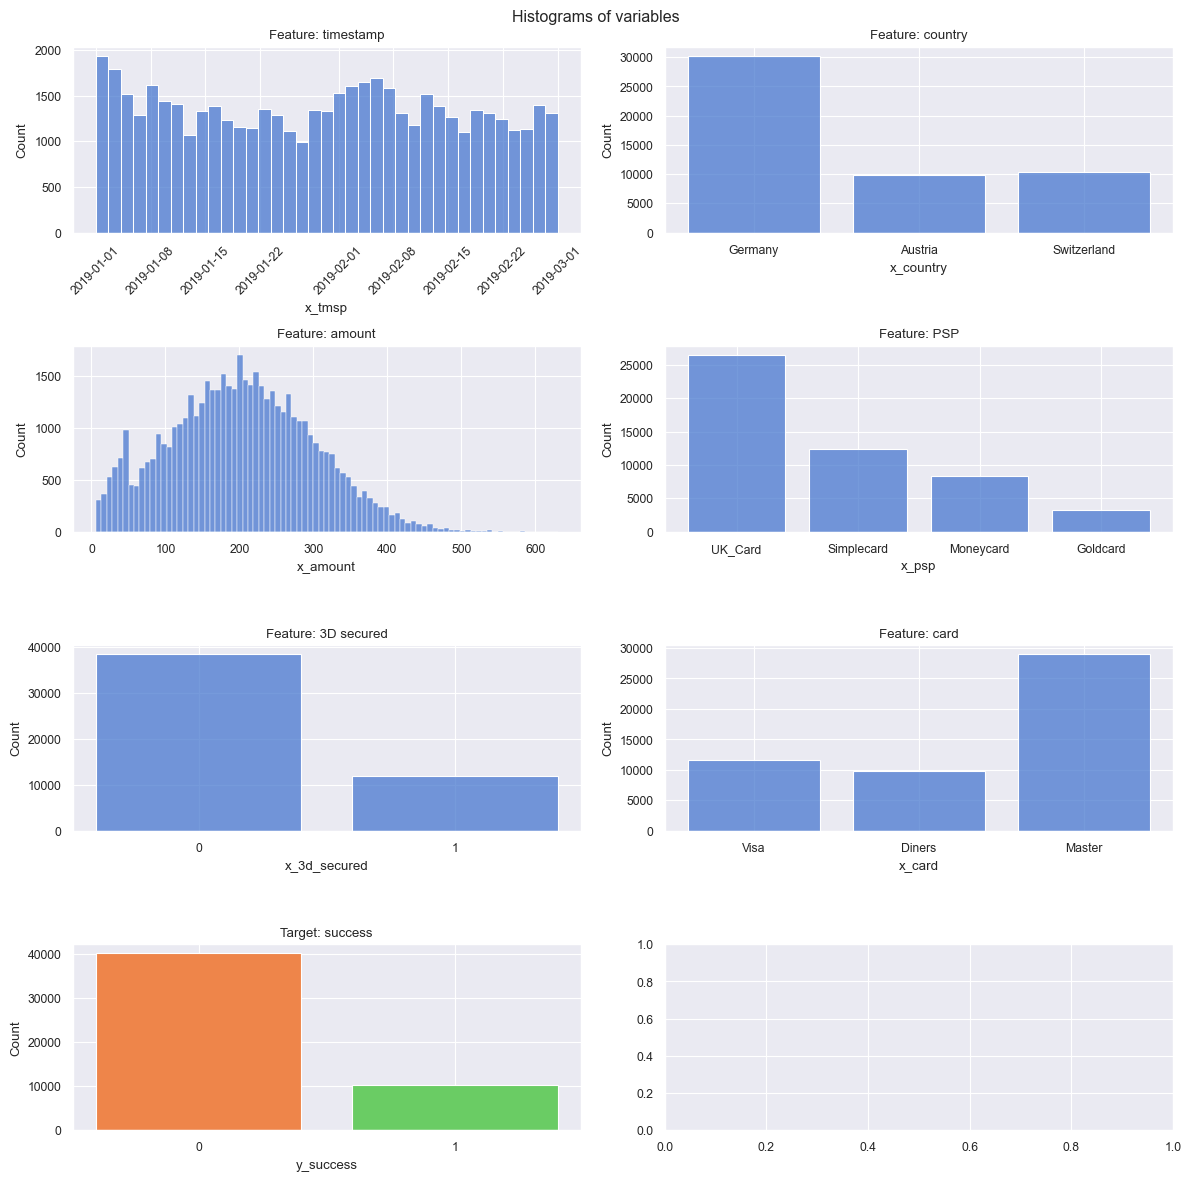

In [9]:
fig, axs = plt.subplots(4,2, figsize=(12, 12), sharex=False, tight_layout=True)

# Timestamp
sns.histplot(df_t_in, x="x_tmsp", stat="count", ax=axs[0, 0])
axs[0, 0].set_title("Feature: timestamp")
for label in axs[0, 0].get_xticklabels():
    label.set_rotation(45)

# Country
sns.histplot(df_t_in, x="x_country", discrete=True, shrink=.8, stat="count", ax=axs[0, 1])
axs[0, 1].set_title("Feature: country")

# Amount
sns.histplot(df_t_in, x="x_amount", stat="count", ax=axs[1, 0])
axs[1, 0].set_title("Feature: amount")

# PSP
sns.histplot(df_t_in, x="x_psp", discrete=True, shrink=.8, stat="count", ax=axs[1, 1])
axs[1, 1].set_title("Feature: PSP")

# 3d_secured
sns.histplot(df_t_in, x="x_3d_secured", discrete=True, shrink=.8, stat="count", ax=axs[2, 0])
axs[2, 0].set_xticks(range(0,2))
axs[2, 0].set_title("Feature: 3D secured")

# card
sns.histplot(df_t_in, x="x_card", discrete=True, shrink=.8, stat="count", ax=axs[2, 1])
axs[2, 1].set_title("Feature: card")

# card
sns.histplot(df_t_in, x="y_success", discrete=True, shrink=.8, stat="count", ax=axs[3, 0])
axs[3, 0].set_xticks(range(0,2))
axs[3, 0].set_title("Target: success")
axs[3, 0].patches[0].set_facecolor(color_pal[1])
axs[3, 0].patches[1].set_facecolor(color_pal[2])

plt.subplots_adjust(hspace=0.3, top = 0.93, bottom = 0.02) 
fig.suptitle("Histograms of variables") 
plt.show() 
plt.close()

> Amount muss genauer angeschaut werden, da es hier einige Ausreißer nach oben gibt

<Figure size 1200x800 with 0 Axes>

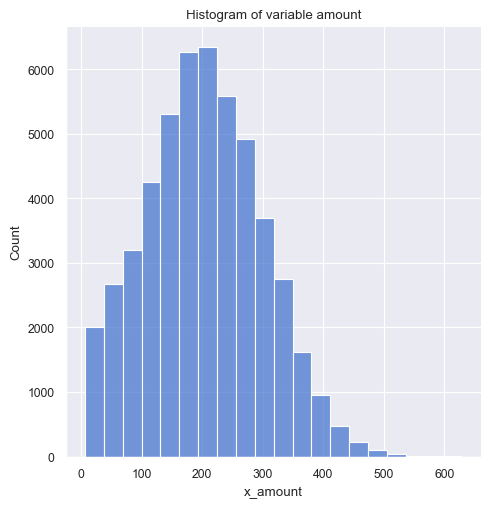

In [10]:
plt.figure(figsize=(plot_width, plot_height))
sns.displot(df_t_in, x="x_amount", bins=20)
plt.title("Histogram of variable amount")
plt.show()
plt.close()

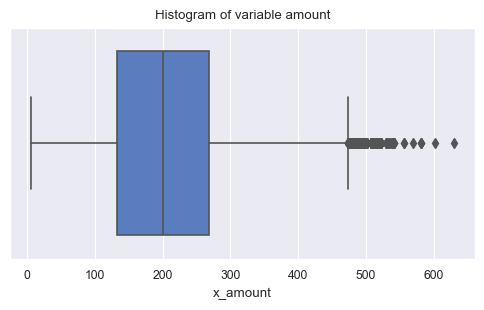

In [11]:
plt.figure(figsize=(6, 3))
sns.boxplot(x="x_amount", orient="h", data=df_t_in)
plt.title("Histogram of variable amount")
plt.show()
plt.close()

Findings:
> Outliers bei Amount: > 500 EUR stehe nur noch sehr wenige Datensätze zur Verfügung. <br>
> Success: Es gibt mehr fehlgeschlagene Versuche, als erfolgreiche Versuche. Daher muss es sehr viele Mehrfachversuche geben, die identifiziert werden müssen.

### Korrelation überprüfen
Es liegt mit "amount" nur sehr wenige numerische Variablen vor, wobei nur die Variable "amount" kontinuierliche Daher kann die Korrelation auch nur begrenzt bewertet werden.<br>
Bei den Korrelation ist wie erwartet sehr schwach, da auch nur sehr wenige numerische Wert

In [12]:
corr_pearson_raw = df_t_in.corr(method="pearson", numeric_only=True)
corr_pearson_raw

,x_amount,y_success,x_3d_secured
x_amount,1.000000,-0.086423,0.000178
y_success,-0.086423,1.000000,0.059284
x_3d_secured,0.000178,0.059284,1.000000


<Axes: >

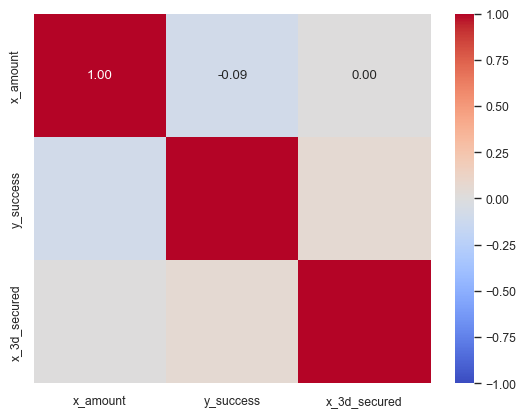

In [13]:
sns.heatmap(corr_pearson_raw, annot=True, vmin=-1, vmax=1, center=0.0, fmt=".2f", cmap="coolwarm")

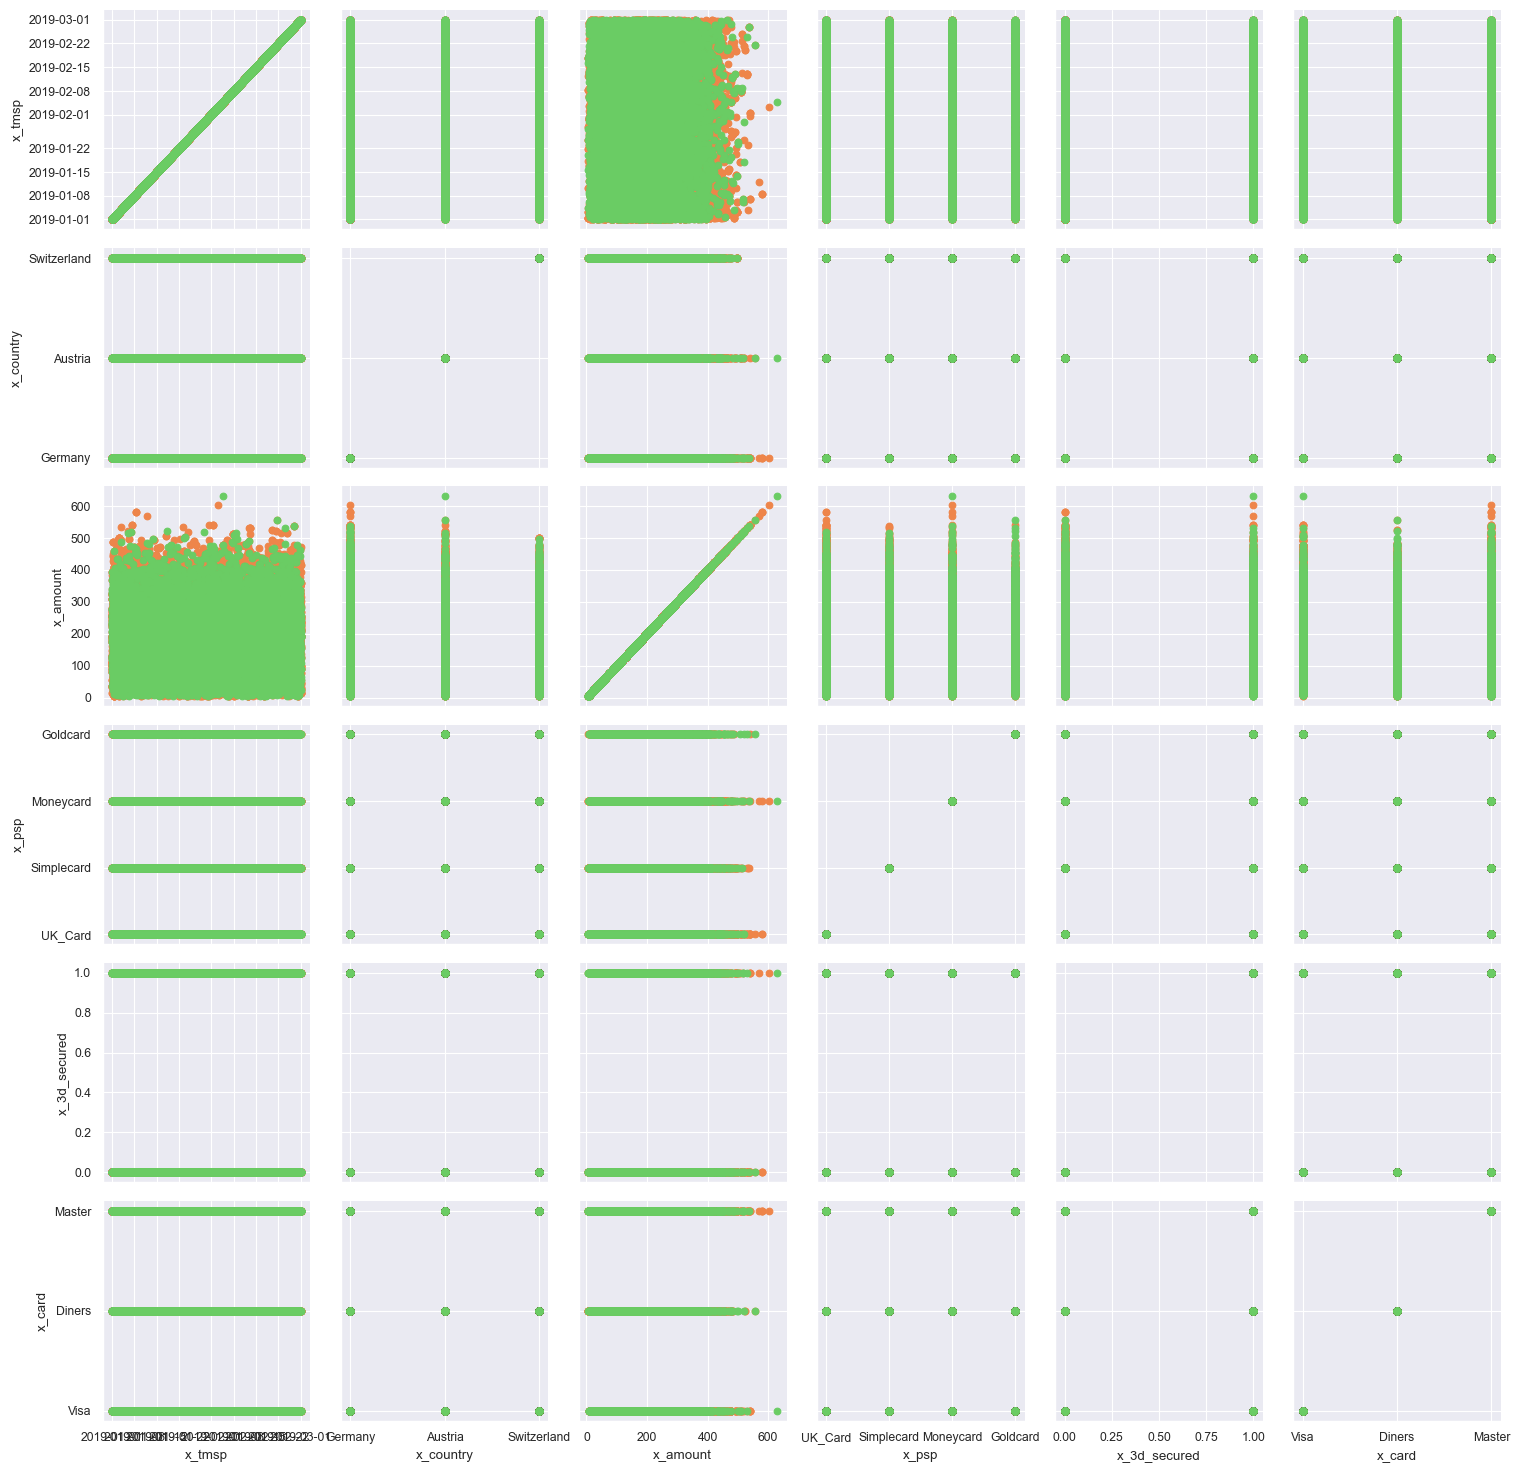

In [14]:
corr_grid = sns.PairGrid(df_t_in, hue=y_raw[0], palette=palette_success, vars=x_raw)
corr_grid.map(plt.scatter)
plt.show()

## Verify data quality
Datenqualität ist gut:
- keine fehlenden Werte
- alle Werte stimmen mit dem erwarteten Datenformat überein

# Data preparation

## Select and clean data
Evtl. Bereinigung der Outliers?

## Construct data
- Mehrfachversuche identifizieren
- Werte kodieren

### Mehrfachversuche identifizieren
Überweisungen werden als mehrfache Zahlungsversuche gezählt, wenn:
- im selben Land
- mit demselben Überweisungsbetrag
- und innerhalb derselben Minute

Zuerst **Auswertung aus der Perspektive des Kunden:**<br>
Bündeln der Transaktionen, die zu einem Kundenvorgang gehören und ggfs. aus mehreren Versuchen des Kunden bestehen.

In [15]:
# sort to get correct order and reset index
df_t_processed = (df_t_in
                  .sort_values(by=["x_country", "x_amount", "x_tmsp"], ascending=True, inplace=False)
                  .reset_index()
                  .drop(columns=["Unnamed: 0"]))

# calculate timedifference between to consecutive rows and convert to minutes
df_t_processed["time_diff_min"] = df_t_processed["x_tmsp"].diff(periods=1).dt.total_seconds().div(60)

# init lists
cust_transaction_id = [] # from customer perspective: ID for each transaction ; can consist of several attempts
cust_attempt_no = [] # from customer perspective: no. of attempts for each transaction

# iter over dataframe
for idx, row in df_t_processed.iterrows():
    if (idx == 0):
        # first rows -> new transaction
        cust_transaction_id.append(0)
        cust_attempt_no.append(1)
    else: # not first row
        country_curr = df_t_processed.at[idx, "x_country"]
        country_prev = df_t_processed.at[idx-1, "x_country"]
        amount_curr = df_t_processed.at[idx, "x_amount"]
        amount_prev = df_t_processed.at[idx-1, "x_amount"]
        timediff = df_t_processed.at[idx, "time_diff_min"]
    
        if (country_curr == country_prev) and (amount_curr == amount_prev) and (timediff <= 60):
            # similar attempt happened already -> same transaction + new attempt
            cust_transaction_id.append(cust_transaction_id[-1])
            cust_attempt_no.append(cust_attempt_no[-1]+1) # take last entry and add 1
        else:
            # different attempt -> new transaction and first attempt
            cust_transaction_id.append(cust_transaction_id[-1]+1)
            cust_attempt_no.append(1)

df_t_processed["meta_customer_trx_id"] = cust_transaction_id
df_t_processed["meta_customer_atpt_no"] = cust_attempt_no
df_t_processed = df_t_processed.drop(columns=["time_diff_min"])

**Auswertung aus der Perspektive der PSPs:**<br>
Innerhalb eines Kundenvorgangs können mehrere unterschiedliche PSPs gewählt werden. Dabei kommt es auch vor, dass ein PSP, mit dem bei diesem Kundenvorgang bereits ein Versuch unternommen wurde, nach erfolglosen Versuchen mit anderen PSPs wieder ausgewählt wird.<br>

Ziel:<br>
Kundenvorgänge aus die PSPs aufteilen und eine eindeutige ID des Kundenvorgangs für den jeweiligen PSP schaffen

In [16]:
df_t_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   x_tmsp                 50410 non-null  datetime64[ns]
 1   x_country              50410 non-null  object        
 2   x_amount               50410 non-null  int64         
 3   y_success              50410 non-null  int64         
 4   x_psp                  50410 non-null  object        
 5   x_3d_secured           50410 non-null  int64         
 6   x_card                 50410 non-null  object        
 7   meta_customer_trx_id   50410 non-null  int64         
 8   meta_customer_atpt_no  50410 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.5+ MB


In [17]:
list_index = []
psp_transaction_id = [] # from PSP perspective: ID for each transaction ; can consist of several attempts
psp_attempt_no = [] # from PSP perspective: no. of attempts for each transaction

for psp in df_t_processed["x_psp"].unique(): # iter over PSPs
    df_filter_psp = df_t_processed[df_t_processed["x_psp"] == psp] # filter by PSP

    list_trx_ids = df_filter_psp["meta_customer_trx_id"].unique() # get all transaction IDs per PSP
    
    for trx_id in list_trx_ids: # iter over transactions
        # records per trax_id
        index_per_trx =  df_filter_psp[df_filter_psp["meta_customer_trx_id"] == trx_id].index

        counter_per_trx = 0 # init counter for attempt no
        # create psp_trx_id
        if len(psp_transaction_id) == 0: # first id
            psp_trx_id = 0
        else:
            psp_trx_id = psp_transaction_id[-1]+1
        
        for index in index_per_trx: # iter over records per trax_id
            list_index.append(index)
            psp_transaction_id.append(psp_trx_id)

            # count attempt per PSP per customer transaction
            counter_per_trx +=1
            psp_attempt_no.append(counter_per_trx)
            

# consolidate data
psp_dict = {"index": list_index, "meta_psp_trx_id": psp_transaction_id, "meta_psp_atpt_no": psp_attempt_no}
df_psp_data = pd.DataFrame(data=psp_dict, columns=["index", "meta_psp_trx_id", "meta_psp_atpt_no"]).set_index("index")
df_t_enrich = df_t_processed.join(df_psp_data, how="left")

In [18]:
#df_t_enrich.tail(20)

### Zeitreiheninformationen
Zusammenhang mit der Zeit:
- Stunde
- Wochentag
- Tag im Monat
- Monat

In [19]:
df_t_enrich["x_tmsp_h"] = df_t_enrich["x_tmsp"].dt.hour
df_t_enrich["x_tmsp_wd"] = df_t_enrich["x_tmsp"].dt.dayofweek
df_t_enrich["x_tmsp_day"] = df_t_enrich["x_tmsp"].dt.day
df_t_enrich["x_tmsp_month"] = df_t_enrich["x_tmsp"].dt.month

### Encoding
One hot encoding of:
- Country
- PSP
- 3D_secured
- Card

In [20]:
# COUNTRY
ohe_country = pd.get_dummies(df_t_enrich["x_country"], prefix="x_country", prefix_sep="_", drop_first=False)

# PSP
ohe_psp = pd.get_dummies(df_t_enrich["x_psp"], prefix="x_psp", prefix_sep="_", drop_first=False)

# 3D_secured
ohe_3d_secured = pd.get_dummies(df_t_enrich["x_3d_secured"], prefix="x_3d_secured", prefix_sep="_", drop_first=False)

# card
ohe_card = pd.get_dummies(df_t_enrich["x_card"], prefix="x_card", prefix_sep="_", drop_first=False)

In [21]:
df_t_encoded = pd.concat(objs=[df_t_enrich, ohe_country, ohe_psp, ohe_3d_secured, ohe_card], axis=1, ignore_index=False)

# Business understanding 2
Um die Ziele der Businessfunktion zu erfüllen, ist es wichtig, einige KPI als Erfoglskriterien zu erfassen. Das Prognosemodell muss besser Ergebnisse erzielen.

In [101]:
#df_t_encoded.describe()

## Kosten für die Transaktionen
Verwendet den gesamten Datensatz

In [88]:
# melt cost df for easy merge with transactions
df_cost_in = df_cost_in.rename(columns={"fee_success_EUR":1, "fee_failed_EUR":0}) # rename first
df_cost_melted = pd.melt(df_cost_in, id_vars="PSP_name", value_vars=[0, 1], var_name="success_fail", value_name="fee_EUR")

df_t_cost = pd.merge(df_t_encoded, df_cost_melted, 
                     how="left", 
                     left_on=["x_psp", "y_success"], right_on=["PSP_name", "success_fail"])

In [106]:
total_fee_eur = df_t_cost["fee_EUR"].sum()

trx_all_count = df_t_encoded.shape[0] # count transactions
customer_payments_count = len(df_t_encoded["meta_customer_trx_id"].unique())

avg_cost_per_trx = total_fee_eur / trx_all_count
avg_cost_per_customer_payment = total_fee_eur / customer_payments_count

print(f"Die gesamten Kosten für die {trx_all_count} Transaktionen belaufen sich auf {total_fee_eur:.0f} EUR.\n Damit ergeben sich durchschnittlich {avg_cost_per_trx:.1f} EUR je Transaktion bzw. {avg_cost_per_customer_payment:.1f} EUR je Bezahlvorgang")

Die gesamten Kosten für die 50410 Transaktionen belaufen sich auf 88544 EUR.
 Damit ergeben sich durchschnittlich 1.8 EUR je Transaktion bzw. 3.3 EUR je Bezahlvorgang


## "First time through" von Kundenvorgängen (Bezahlvorgängen)
Relevant aus Kundenperspektive

<Figure size 1200x800 with 0 Axes>

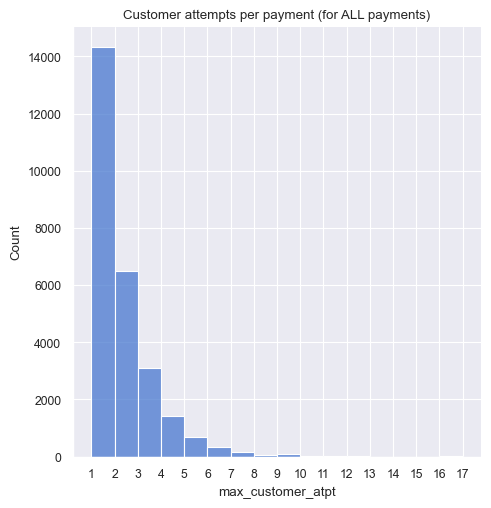

In [26]:
# for ALL payments: attempts per customer
attempts_per_customer = (df_t_encoded.groupby(["meta_customer_trx_id"])["meta_customer_atpt_no"].max()
                         .reset_index()
                         .rename(columns={"meta_customer_atpt_no":"max_customer_atpt"}))

plt.figure(figsize=(plot_width, plot_height))
g = sns.displot(attempts_per_customer, x="max_customer_atpt", bins=df_t_encoded["meta_customer_atpt_no"].unique())
plt.xticks(df_t_encoded["meta_customer_atpt_no"].unique())
#g.set_xticklabels(df_t_encoded["meta_customer_atpt_no"].unique())
plt.title("Customer attempts per payment (for ALL payments)")
plt.show()
plt.close()

In [111]:
# average no. of attempts for a customer
avg_atpt_per_customer = attempts_per_customer["max_customer_atpt"].mean()
print(f"Ein Kunde muss im Schnitt {avg_atpt_per_customer:.2f} Versuche unternehmen, um die Bezahlung durchzuführen.")

Ein Kunde muss im Schnitt 1.89 Versuche unternehmen, um die Bezahlung durchzuführen.


In [28]:
# FTT: first time through
attempts_per_customer["FTT"] = attempts_per_customer["max_customer_atpt"].apply(lambda x: True if x==1 else False)

# group by FTT
ftt_calculate = (attempts_per_customer.groupby(["FTT"])[["meta_customer_trx_id"]].count().reset_index()
                 .rename(columns={"meta_customer_trx_id":"payments_count"}))

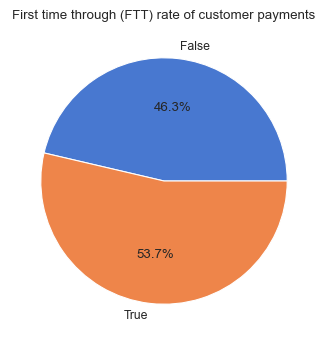

In [29]:
plt.figure(figsize=(plot_width-4, plot_height-4))
plt.pie(ftt_calculate["payments_count"], labels=ftt_calculate["FTT"], autopct='%1.1f%%')
plt.title("First time through (FTT) rate of customer payments")
plt.show()
plt.close()

# Data understanding 2

## Collect data
Für das Prognosemodell ist es sinnvoll, nur die jeweils ersten Versuche eines PSPs für einen Kundenvorgang zu nehmen.
> Filtern nach "meta_psp_atpt_no" = 1.<br>
> Damit können je Kundenvorgang mehrere Transaktionen berücksichtigt werden, aber für jeden PSP wird der Kundenvorgang nur 1 Mal aufgenommen und fließt in das Modell ein.

In [22]:
df_t_encoded.groupby(["meta_psp_atpt_no"])["x_tmsp"].count()

meta_psp_atpt_no
1    37612
2     8888
3     2611
4      830
5      297
6      126
7       35
8        7
9        4
Name: x_tmsp, dtype: int64

In [100]:
df_trx = df_t_encoded[df_t_encoded["meta_psp_atpt_no"] == 1]
df_trx.shape
print(f"Wenn je PSP nur der 1. Versuch berücksichtigt wird, verbleiben {df_trx.shape[0]} Datensätze")

Wenn je PSP nur der 1. Versuch berücksichtigt wird, verbleiben 37612 Datensätze


In [124]:
# raw x- and y-variables
x_ = [x for x in list(df_trx.columns) if re.match("^x_", x)!=None]
y_ = [y for y in list(df_trx.columns) if re.match("^y_", y)!=None]
meta_ = [m for m in list(df_trx.columns) if m.find("meta_")!=-1]

## Describe data

In [25]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37612 entries, 0 to 50404
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   x_tmsp                 37612 non-null  datetime64[ns]
 1   x_country              37612 non-null  object        
 2   x_amount               37612 non-null  int64         
 3   y_success              37612 non-null  int64         
 4   x_psp                  37612 non-null  object        
 5   x_3d_secured           37612 non-null  int64         
 6   x_card                 37612 non-null  object        
 7   meta_customer_trx_id   37612 non-null  int64         
 8   meta_customer_atpt_no  37612 non-null  int64         
 9   meta_psp_trx_id        37612 non-null  int64         
 10  meta_psp_atpt_no       37612 non-null  int64         
 11  x_tmsp_h               37612 non-null  int32         
 12  x_tmsp_wd              37612 non-null  int32         
 13  x_tmsp

## Explore data

### Erfolgsquote je PSP
Für den jeweiligen PSP die erste Transaktion je Kundenvorgang

In [49]:
success_rate = (df_trx.groupby(["x_psp", "y_success"])[["meta_psp_trx_id"]].count()
                .reset_index()
                .rename(columns={"meta_psp_trx_id":"count"})
                .pivot(index="x_psp", columns="y_success", values="count")
                .reset_index())
success_rate["total"] = success_rate[0] + success_rate[1]
success_rate["1_share"] = success_rate[1] / success_rate["total"] * 100
success_rate["total_share"] = success_rate["total"] / success_rate["total"] * 100

In [72]:
# calculate overall success rate over all PSPs
overall_success_rate = success_rate[1].sum(axis=0) / success_rate["total"].sum(axis=0) * 100

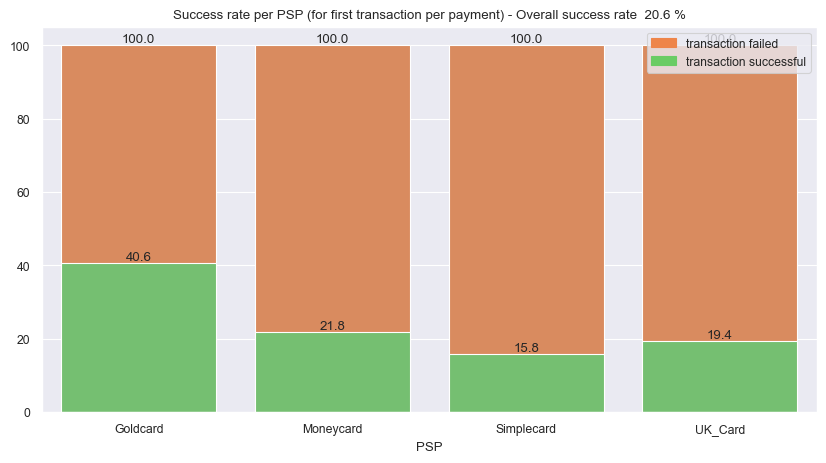

In [76]:
# https://python-graph-gallery.com/stacked-and-percent-stacked-barplot/
plt.figure(figsize=(plot_width-2, plot_height-3))
# bar chart 1 -> top bars (total_share = 100%)
bar1 = sns.barplot(x="x_psp",  y="total_share", data=success_rate, color=color_pal[1])

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="x_psp",  y="1_share", data=success_rate, color=color_pal[2])
for i in bar2.containers:
    bar2.bar_label(i, fmt="%.1f")
bar2.set(xlabel="PSP")
bar2.set(ylabel=None)

# add legend
top_bar = mpatches.Patch(color=color_pal[1], label="transaction failed")
bottom_bar = mpatches.Patch(color=color_pal[2], label="transaction successful")
plt.legend(handles=[top_bar, bottom_bar])

plt.title(f"Success rate per PSP (for first transaction per payment) - Overall success rate {overall_success_rate: .1f} %")
plt.show()
plt.close()

### Verteilung über Histogramme

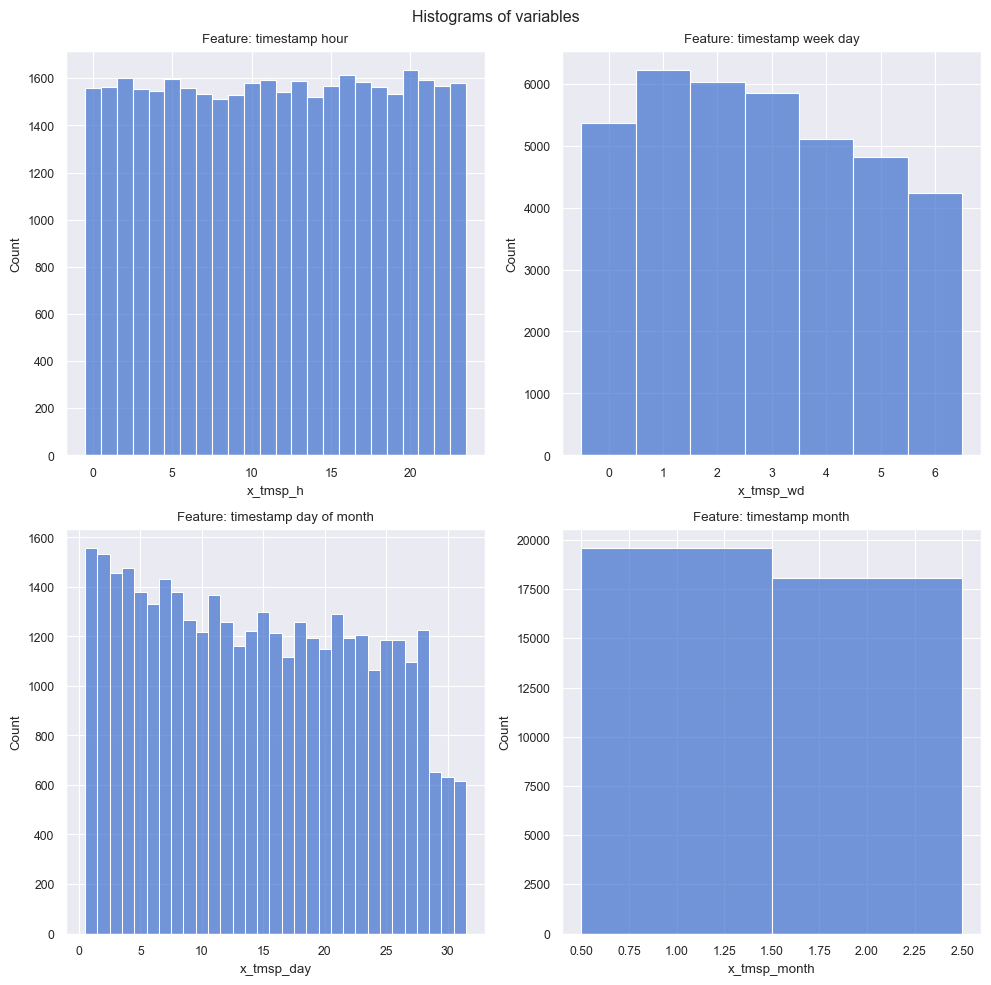

In [115]:
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=False, tight_layout=True)

# Timestamp hour
sns.histplot(df_trx, x="x_tmsp_h", stat="count", ax=axs[0, 0], discrete=True)
axs[0, 0].set_title("Feature: timestamp hour")

# Timestamp week day
sns.histplot(df_trx, x="x_tmsp_wd", stat="count", ax=axs[0, 1], discrete=True)
axs[0, 1].set_title("Feature: timestamp week day")

# Timestamp day of month
sns.histplot(df_trx, x="x_tmsp_day", stat="count", ax=axs[1, 0], discrete=True)
axs[1, 0].set_title("Feature: timestamp day of month")

# Timestamp month
sns.histplot(df_trx, x="x_tmsp_month", stat="count", ax=axs[1, 1], discrete=True)
axs[1, 1].set_title("Feature: timestamp month")

plt.subplots_adjust(hspace=0.3, top = 0.93, bottom = 0.02) 
fig.suptitle("Histograms of variables") 
plt.show() 
plt.close()

### Korrelation überprüfen

In [129]:
corr_pearson_trx = df_trx[x_ + y_].corr(method="pearson", numeric_only=True)

<Axes: >

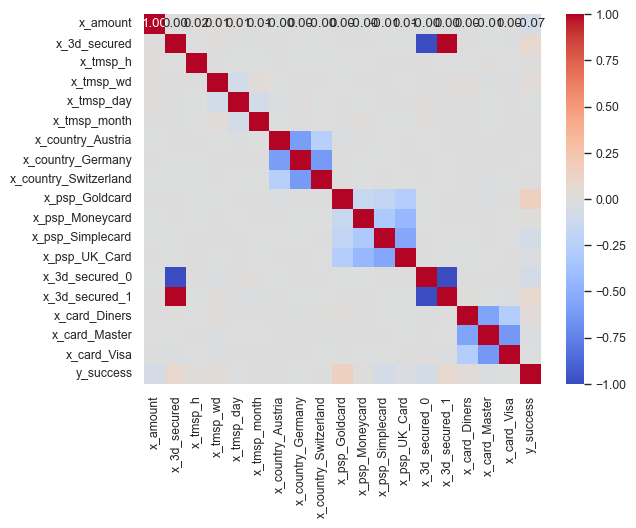

In [130]:
sns.heatmap(corr_pearson_trx, annot=True, vmin=-1, vmax=1, center=0.0, fmt=".2f", cmap="coolwarm")

In [132]:
"""corr_grid_trx = sns.PairGrid(df_trx, hue=y_raw[0], palette=palette_success, vars=x_)
corr_grid_trx.map(plt.scatter)
plt.show()"""

'corr_grid_trx = sns.PairGrid(df_trx, hue=y_raw[0], palette=palette_success, vars=x_)\ncorr_grid_trx.map(plt.scatter)\nplt.show()'

# Save feature data

In [134]:
df_trx.to_excel("../data/03_interim/df_trx_training.xlsx", sheet_name="df_trx")